# Initialization

In [17]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

In [2]:
train=pd.read_csv('../data/data.csv.zip', compression='zip', index_col=1)
train=train.drop(columns=['Unnamed: 0'])

# Data cleaning

In [3]:
train.columns = train.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
train=train.drop(columns=['photo', 'flag', 'club_logo'])

train['value_unit'] = train['value'].str[-1]
train['nvalue'] = np.where(train['value_unit'] == '0', 0,
                          train['value'].str[1:-1].replace(r'[a-zA-Z]',''))
train['nvalue'] = train['nvalue'].astype(float)
train['nvalue'] = np.where(train['value_unit'] == 'M', train['nvalue'], train['nvalue'] / 1000)

train['wage_unit'] = train['wage'].str[-1]
train['nwage'] = np.where(train['wage_unit'] == '0', 0,
                          train['wage'].str[1:-1].replace(r'[a-zA-Z]',''))
train['nwage'] = train['nwage'].astype(float)
train['nwage'] = np.where(train['wage_unit'] == 'K', train['nwage'], train['nwage'] * 1000)


# Features selection

In [4]:
features = ['aggression', 'age', 'potential', 
                        'international_reputation',
                        'weak_foot', 'skill_moves', 'crossing', 'finishing', 'headingaccuracy', 
                        'shortpassing', 'volleys', 'dribbling', 'curve', 'fkaccuracy', 'longpassing',
                        'ballcontrol', 'acceleration', 'sprintspeed',
                        'agility', 'reactions', 'balance', 'shotpower', 'jumping', 'stamina', 
                        'strength',
                        'longshots', 'aggression', 'interceptions', 'positioning', 'vision', 
                        'penalties',
                        'composure', 'marking', 'standingtackle', 'slidingtackle', 'gkdiving', 
                        'gkhandling', 'gkkicking', 'gkpositioning', 'gkreflexes']


# Drop missing values.

In [5]:
def drop_missing_values(train, columns):
    df = train.dropna(subset=columns)
    return df


In [6]:
t=features.copy()
t.append('overall')

In [7]:
# train_d = train.dropna(subset=t)
train_d = drop_missing_values(train, t)

In [8]:
X=train_d[features]
y=train_d.overall

# Define Models

In [9]:
models = []
models.append(('LR', linear_model.LinearRegression()))
models.append(('BR', linear_model.BayesianRidge(n_iter=1000)))
models.append(('Huber', linear_model.HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, 
                                                    max_iter=100, tol=1e-05, warm_start=False)))
models.append(('LarsCV', linear_model.LarsCV(max_iter=1000, eps=1.35, cv=10)))
models.append(('LassoCV', linear_model.LassoCV(max_iter=1000, cv=5)))
models.append(('RF', ensemble.RandomForestRegressor(n_estimators=10)))

# Model fitting and prediction

## Using cross validation

In [10]:
def cv_fit_and_predict(models, X, y):
    results = []
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
    for name, model in models:
        model.fit(train_X, train_y)
        y_pred = model.predict(val_X)
        score = cross_val_score(model, X, y, cv=10)
        print('Model {0} score: {1:.4f} and std dev: {2:.4f}'.format(name, score.mean(), score.std()))
        # The coefficients
        # print('Coefficients: \n', model.coef_)
        # The mean squared error
        print("Mean squared error: %.4f"
              % mean_squared_error(val_y, y_pred))
        print("Mean absolute error: %.4f" %mean_absolute_error(val_y, y_pred))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.4f' % r2_score(val_y, y_pred))
        # Regression score 
        # print('Regression score: %.4f' % model.score(X, y))
        results.append((name, score, r2_score(val_y, y_pred)))
        try:
            i
        except NameError:
            i=score.mean()-1        
        if score.mean() > i :
            imodel=model
            i=score.mean()

    print("Done")
    return results


In [11]:
results = cv_fit_and_predict(models, X, y)

Model LR score: -5.0360 and std dev: 3.5004
Mean squared error: 3.4297
Mean absolute error: 1.4506
Variance score: 0.9274
Model BR score: -5.0340 and std dev: 3.5073
Mean squared error: 3.4303
Mean absolute error: 1.4506
Variance score: 0.9274
Model Huber score: -5.6204 and std dev: 3.6732
Mean squared error: 4.1033
Mean absolute error: 1.5875
Variance score: 0.9131
Model LarsCV score: -8.0375 and std dev: 2.8204
Mean squared error: 7.3785
Mean absolute error: 2.1449
Variance score: 0.8438
Model LassoCV score: -5.0982 and std dev: 3.6074
Mean squared error: 3.4773
Mean absolute error: 1.4607
Variance score: 0.9264
Model RF score: -3.3356 and std dev: 1.2895
Mean squared error: 1.4737
Mean absolute error: 0.8365
Variance score: 0.9688
Done


# Validation and Results

In [12]:
def model_validation(results):
    fig, ax = plt.subplots()
    ax.boxplot(results[:,1])
    ax.set_xticklabels(results[:,0])
    ax.set_title('Model CV score')
    plt.show()
    
    plt.figure(figsize=(8, 5))
    plt.bar(results[:,0], results[:,2])
    plt.xlabel('Models')
    plt.ylabel('Var score')
    plt.title('Models variance score')
    plt.show()
    
    return 0

In [13]:
results=np.array(results)

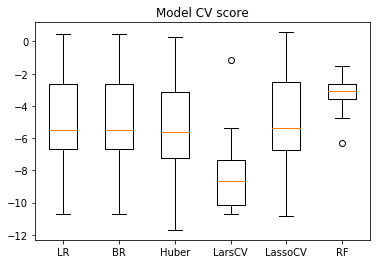

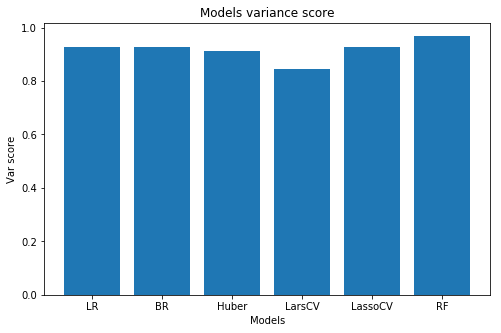

In [14]:
status = model_validation(results)

# Handling missing values - Imputation

In [20]:
def imputation_cv(models, X, y):
    results = []
#    si = SimpleImputer()
    train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)
#    train_X = si.fit_transform(train_X)
#    val_X = si.fit_transform(val_X)
    for name, model in models:
        my_pipeline = make_pipeline(SimpleImputer(), models)
        my_pipeline.fit(train_X, train_y)
        predictions = my_pipeline.predict(val_X)
#        model.fit(train_X, train_y)
#        y_pred = model.predict(val_X)
        score = cross_val_score(my_pipeline, X, y, cv=10)
        print('Model {0} score: {1:.4f} and std dev: {2:.4f}'.format(name, score.mean(), score.std()))
        # The coefficients
        # print('Coefficients: \n', model.coef_)
        # The mean squared error
        print("Mean squared error: %.4f"
              % mean_squared_error(val_y, y_pred))
        print("Mean absolute error: %.4f" %mean_absolute_error(val_y, y_pred))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.4f' % r2_score(val_y, y_pred))
        # Regression score 
        # print('Regression score: %.4f' % model.score(X, y))
        results.append((name, score, r2_score(val_y, y_pred)))
        try:
            i
        except NameError:
            i=score.mean()-1        
        if score.mean() > i :
            imodel=model
            i=score.mean()

    print("Done")
    return results


In [21]:
X = train[features]
y = train.overall
results = imputation_cv(models, X, y)

TypeError: Last step of Pipeline should implement fit. '[('LR', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)), ('BR', BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=1000,
       normalize=False, tol=0.001, verbose=False)), ('Huber', HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
        tol=1e-05, warm_start=False)), ('LarsCV', LarsCV(copy_X=True, cv=10, eps=1.35, fit_intercept=True, max_iter=1000,
    max_n_alphas=1000, n_jobs=None, normalize=True, positive=False,
    precompute='auto', verbose=False)), ('LassoCV', LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)), ('RF', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]' (type <class 'list'>) doesn't

In [ ]:
results=np.array(results)
status = model_validation(results)

# Imputation extension 

In [ ]:
train.columns

In [ ]:
# make copy to avoid changing original data (when Imputing)
new_data = X.copy()

# make new columns indicating what will be imputed
cols_with_missing = (col for col in new_data.columns 
                                 if new_data[col].isnull().any())
for col in cols_with_missing:
    new_data[col + '_was_missing'] = new_data[col].isnull()

# Imputation
my_imputer = SimpleImputer()
new_data = pd.DataFrame(my_imputer.fit_transform(new_data))
new_data.columns = X.columns
